# Week 3, Data science in Neuroscience

## Plan for today

1. Quick review of last week's exercises
2. Why and how are in-vivo recordings performed?
3. Detecting action potentials (spikes) from raw extracellular recordings and spike clustering
    * Filtering out unwanted frequencies from signals (1st session)
    * Detecting spike events in the filtered signals (2nd session)
    * Extracting spike waveforms from raw signals (2nd session)
    * Dimensionality reduction of spike waveforms (3rd session)
    * Clustering spike waveforms (3rd session)
***

Quick review of what we did yesterday

In [1]:
import numpy as np
import matplotlib.pyplot as plt

fileName = "../data/shortRaw.npy" # binder users or people with a local git repository
dat = np.load(fileName)

In [2]:
from scipy.signal import butter, sosfiltfilt

Filtering of raw signal

In [3]:
def create_butter_highpass_filter(lowcut, fs, order=3):
    """
    Function to create a Butterworth filter using scipy.signal.butter()
    
    Arguments:
    lowcut: low cut frequency in Hz
    fs: sampling rate in Hz
    order: order of the fitler
    
    Returns
    nth-order sections representation of the IIR filter. 
    
    For more information, see https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html
    """
    nyq = 0.5 * fs # Nyquist frequency (sampling rate/2)
    low = lowcut / nyq # lowcut as a proportion of Nyquist frequency
    sos = butter(order, [low], btype='highpass' ,  output='sos') #‘sos’ should be used for general-purpose filtering.
    return sos


In [4]:
fs = 20000 # sampling rate, or samples per seconds, this is in Hz.
lowcut=300 # lowest frequency that will remain in our signal, 300 Hz
myFilter = create_butter_highpass_filter(lowcut = lowcut,fs=fs, order=3)

In [5]:
y = sosfiltfilt(myFilter, dat)

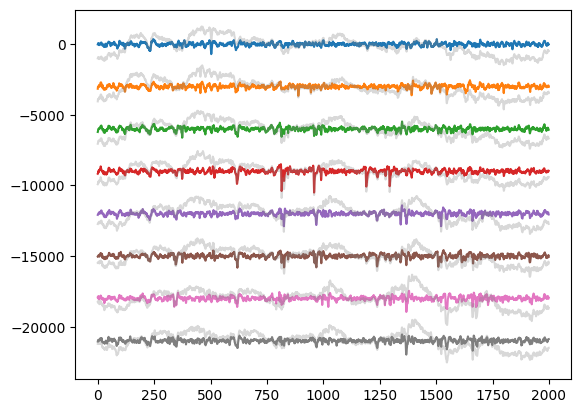

In [8]:
offset=3000
for i in range(y.shape[0]):
    plt.plot(y[i,2000:4000]-offset*i)
    plt.plot(dat[i,2000:4000]-offset*i,color="gray",alpha=0.3)

***
## Detecting spikes

We have removed slow owcillations from the raw signal. We can try to identify spikes in the filtered signal.

One simple strategy is to calculate the **mean** and **standard deviation** of the filtered signal. A spike occures each time the signal reaches 5 standard deviation below the mean. This is the __spike detection threshold__.


Steps:

* Calculate mean and standard deviation
* Calculate the spike detection threshold
* Detect the events that reached the spike detection threshold

### Calculating the mean and standard deviation

We will use a single channel (chan=3) to simplify the problem.


### Exercise

* Calculate and print the mean and standard deviation of channel indexed 3

In [13]:
chan = 3
chanMean = y[chan,:].mean()
print("Mean of channel 3:",chanMean)
chanStd = y[chan,:].std()
print("Standard deviation of channel 3:",chanStd)

Mean of channel 3: 0.040036583062989094
Standard deviation of channel 3: 140.0146706903993


* Calculate the spike detection threshold

* Plot the data to check if this makes sense.

### Detect events that reached the spike detection threshold

We now need to find the trough of the detected spikes. 

Detecting spikes in our signal is a specific example of finding local peaks into a signal. 


Here is how I would approach this problem:

* Investigate whether there is a function already available to help you. Try googling `python find peaks`.


The first result of a Google search points here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html

Most of our spikes are negative but the `scipy.signal.find_peaks()` function is looking for positive peaks. Let's reverse our filtered data to get positive peaks.

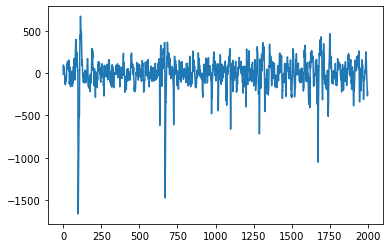

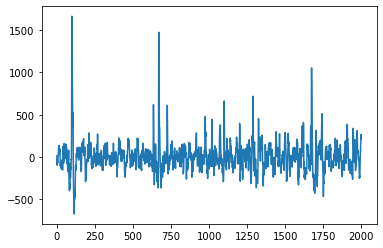

In [19]:
nSamples=2000

## important point about np.arrays
yDetect = y[chan,:].copy() # use a copy of the data to avoid destroying it during the manipulation

plt.plot(yDetect[0:nSamples])
plt.show()

# invert the signal to get positive peaks
yDetect = 0 - yDetect # inverse 
plt.plot(yDetect[0:nSamples])
plt.show()

[`scipy.signal.find_peaks`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html) can identify the time of the peaks (spikes) for us.

In [20]:
from scipy.signal import find_peaks
spikeTimes, _ = find_peaks(x=yDetect,height=0-threshold) # The function returns 2 values. We want the first one
print("Number of detected spikes:",spikeTimes.shape[0])

Number of detected spikes: 23


We plot the filtered signal with the detected spike times. Always plot the results to make sure you get what you expect.

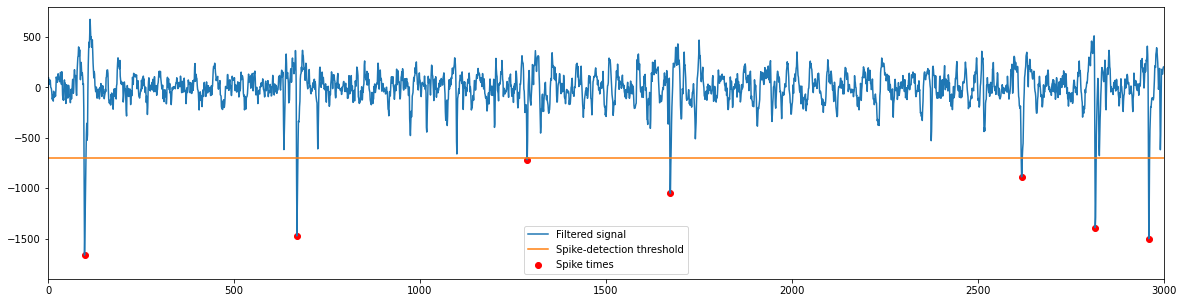

In [21]:
chan=3 # select a channel to work with
nSamples=3000
plt.figure(figsize=(20,5))
plt.plot(y[chan,:nSamples],label="Filtered signal")
plt.scatter(spikeTimes,y[chan,spikeTimes],c="red",label="Spike times")
plt.plot([0,nSamples],[threshold,threshold],label="Spike-detection threshold") 
plt.xlim(0,nSamples)
plt.legend()
plt.show()

The negative spikes crossing the spike-detection threshold are identified correctly by the find_peaks() function.

# Exercises

We have now applied several processing steps to our original data.

* Filtering
* Inverting
* Spike detection

We want to apply this to our 8 recording channels. 


1. Write the code that applies our spike detection procedure to the 8 recording channels in our data. You can use a `for` loop to iterate over the 8 channels. Try to use copy-and-paste from the code above is possible.

2. Store the spike times in a list of NumPy arrays.
    
3. Plot the data from all channels with their threshold and detected spikes. This would confirm that your spike detection worked.


In [ ]:
spikeTimesList

***

## Writing functions

During the last session, we develop our code line-by-line to process the data. We made sure all steps worked as expected by plotting the data.

We did not write many functions. This makes it harder to re-run this same code.

### Why using functions is a good idea?

1. Organize your code in a clear way (one function perform one important processing step)
2. Make it easy to re-run your code (one line call to a function executes many hidden lines of code)
4. Easier to maintain: If there is a bug in the code, it is better if there is only one copy of it!


### Steps to write functions (the easy way)

1. Don't start with a function. Start by running your analysis line-by-line in an interactive environment (Jupyter notebook)
2. Once the code is working, write a function (copy your working code in a function)
4. Always document your function (what does it do, what are the inputs (arguments), what are the outputs)


### Debugging function

If a function is not working as expected (bug?), you need to investigate what it does in more details. 

It is sometimes easier to run the code of the function line by line in a jupyter notebook and plot the results at each step if possible.

**Divide and conquer strategy to find bugs**: Break your problem into small components that you can test individually. Repeat this strategy until you find the bug!


### Three functions to simplify our workflow

In [14]:
def plot_recording_data(dat, offset=3000, startSample=0, endSample=5000):
    """
    Function to plot our electrophysiology data
    
    Arguments
    dat: 2D numpy array containing in-vivo recordings. The dimensions are : [channel,sample]
    offset: offset between each channel to avoid plotting all channels on top of each other
    startSample: first sample to show
    endSample: last sample to show
    """
    
    plt.figure(figsize=(20,10)) # set the size of the figure
    for i in range(dat.shape[0]): #loop for every channel
        plt.plot(dat[i,startSample:endSample]-i*offset,label=i) # plot the channel, apply the y-offset so that the channels are not all on top of each other
    plt.legend()
    plt.show()
    
def create_butter_highpass_filter(lowcut, fs, order=3):
    """
    Create a highpass Butterworth filter using scipy.signal.butter()
    
    Arguments:
    lowcut: low cut frequency 
    fs: sampling rate
    order: order of the filter
    
    Return:
    The function returns a filter in the sos format
    """
    nyq = 0.5 * fs # Nyquist frequency (sampling rate/2)
    low = lowcut / nyq # lowcut as a proportion of Nyquist frequency
    sos = butter(order, [low], btype='highpass' ,  output='sos') #‘sos’ should be used for general-purpose filtering.
    return sos


def filter_raw_data(dat,lowcut=200, fs=20000):
    """
    Function to filter the raw data by applying a highpass filter
    
    Arguments:
    dat: 2D numpy array containing raw in-vivo recordings. The dimensions are : [channel,sample]
    lowcut: low cut frequency 
    fs: sampling rate
    order: order of the filter
    
    Return:
    Filtered data as a 2D numpy array
    """
    # filter the data
    myFilter = create_butter_highpass_filter(lowcut = lowcut,fs=fs, order=3)
    y = sosfiltfilt(myFilter, dat) # the sosfilt() function can take a 2D array and will filter every row separately
    return y


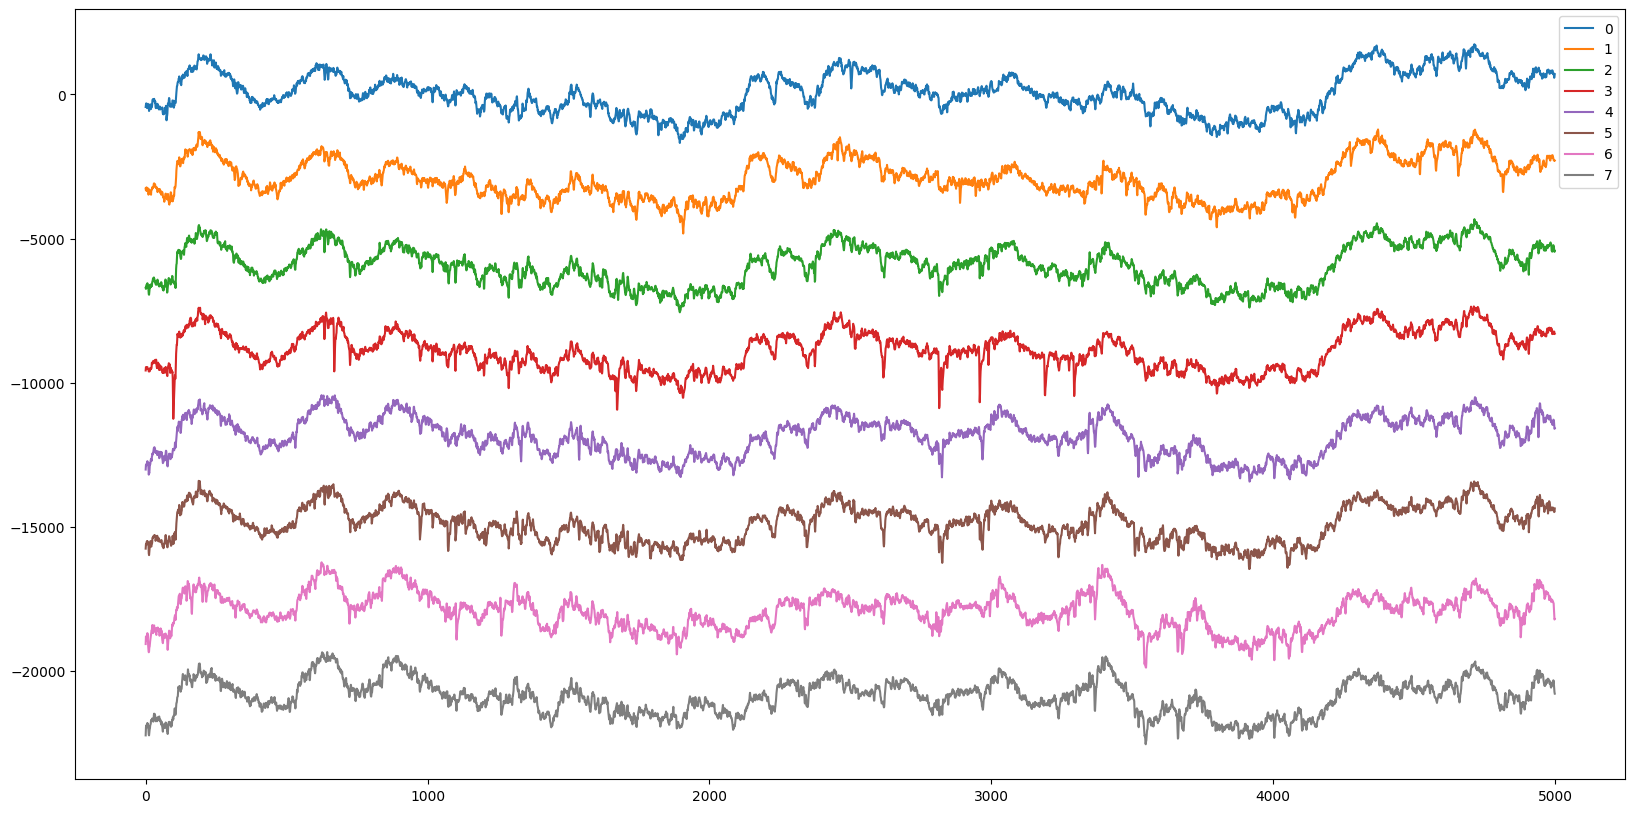

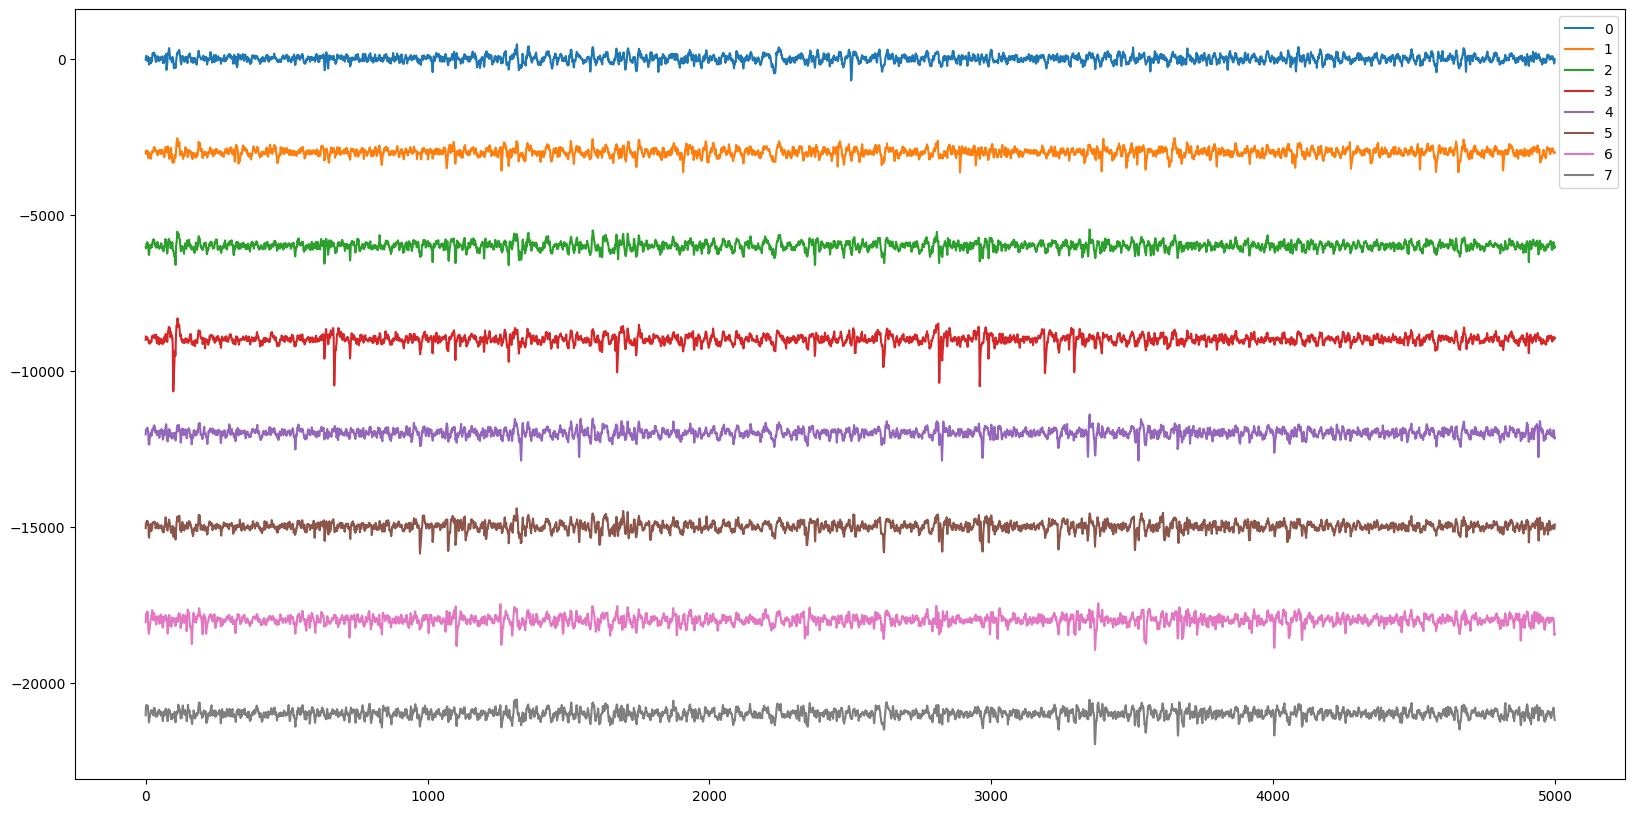

In [15]:
fs = 20000 # sampling rate
lowcut=300

plot_recording_data(dat) # plot raw data
y = filter_raw_data(dat,lowcut = lowcut, fs=fs)  # filter the data
plot_recording_data(y) # plot the filtered data

We can organize this code as 2 functions. 

In [8]:
def spike_detection(y,z=5):
    """
    Function to perform spike detection on filtered in-vivo recordings from the brain. It gets you the time at which spikes were detected on each channel
    
    
    Arguments:
    y: 2D numpy array containing filtered in-vivo recordings. The dimensions are : [channel,sample]
    z: threshold in standard deviations from the mean for spike detection
    
    
    Returns:
    spikeTimes: List of numpy arrays containing the times of spikes detected on each channel. 
    """
    z=5 # we want spikes to be at least 5 standard deviation from the mean

    # We can use Numpy mean, std to calculate the mean of each channel without a for loop
    means=y.mean(axis=1)
    stds=y.std(axis=1)
    thresholds = means-stds*z

    # We need to copy our filtered data 
    yDetect = y.copy() # use a copy of the data to avoid destroying it during the manipulation

    # Inverse the polarity of the signal
    yDetect = 0 - yDetect

    # Create an empty list to store the spikes detected on each channel
    spikeTimesList = [] 

    # loop to detect the spikes on each channel
    for i in range(y.shape[0]):
        spikeTimes, _ = find_peaks(x=yDetect[i,:],height=0-thresholds[i]) # the function returs 2 values, we want the first one
        spikeTimesList.append(spikeTimes)
        print("Detection chan {}, {} spikes".format(i,spikeTimes.shape[0]))
    
    return spikeTimesList,thresholds

def plot_spike_detection(y,spikeTimesList,thresholds,offset=3000):
    """
    Function to plot the results of our spike detection procedure
    
    Arguments:
    y: 2D numpy array containing the filtered data
    spikeTimeList: list of 1D numpy arrays. each array contains the times of the spikes detected on one channel
    threholds: 1D numpy array containing the detection thresholds for each channel
    offset: y offset for plotting the data of each channel. To avoid plotting data on top of each other
    """
    
    plt.figure(figsize=(20,20)) # set the size of the figure
    for i in range(y.shape[0]): #loop for every channel
        plt.plot(y[i,:]-i*offset,label=i) # plot the channel, apply the y-offset so that the channels are not all on top of each other
        plt.plot([0,y.shape[1]],[thresholds[i]-i*offset,thresholds[i]-i*offset]) # plot the threshold
        plt.scatter(spikeTimesList[i],y[i,spikeTimesList[i]]-i*offset,c="red") # plot the spikes
    plt.legend()
    plt.show()

## Create a spikeDetection module for our functions

Once your functions are tested, you can define them in a separate `.py` file and import them as a Python module. 

More [information on modules](https://docs.python.org/3/tutorial/modules.html)

For instance, we can put our 5 functions in a file called `spikeDetection.py` located in the same directory as this notebook. The file needs to end with `.py`

We can run the file to define our function as follows.

Modules are essential when we work with larger projects. You don't want to have to define the functions all the time!

Here is how to use our `spikeDetection` module. See how quickly we can re-run all our analysis.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import spikeDetection # we import all the function defined in spikeDetection.py
# alternatively: from spikeDetection import plot_recording_data, filter_raw_data, spike_detection, plot_spike_detection
# with from ... import ... you call the function without the module name: plot_spike_detection() and not spikeDetection.plot_spike_datection()

In [ ]:
spikeDetection.

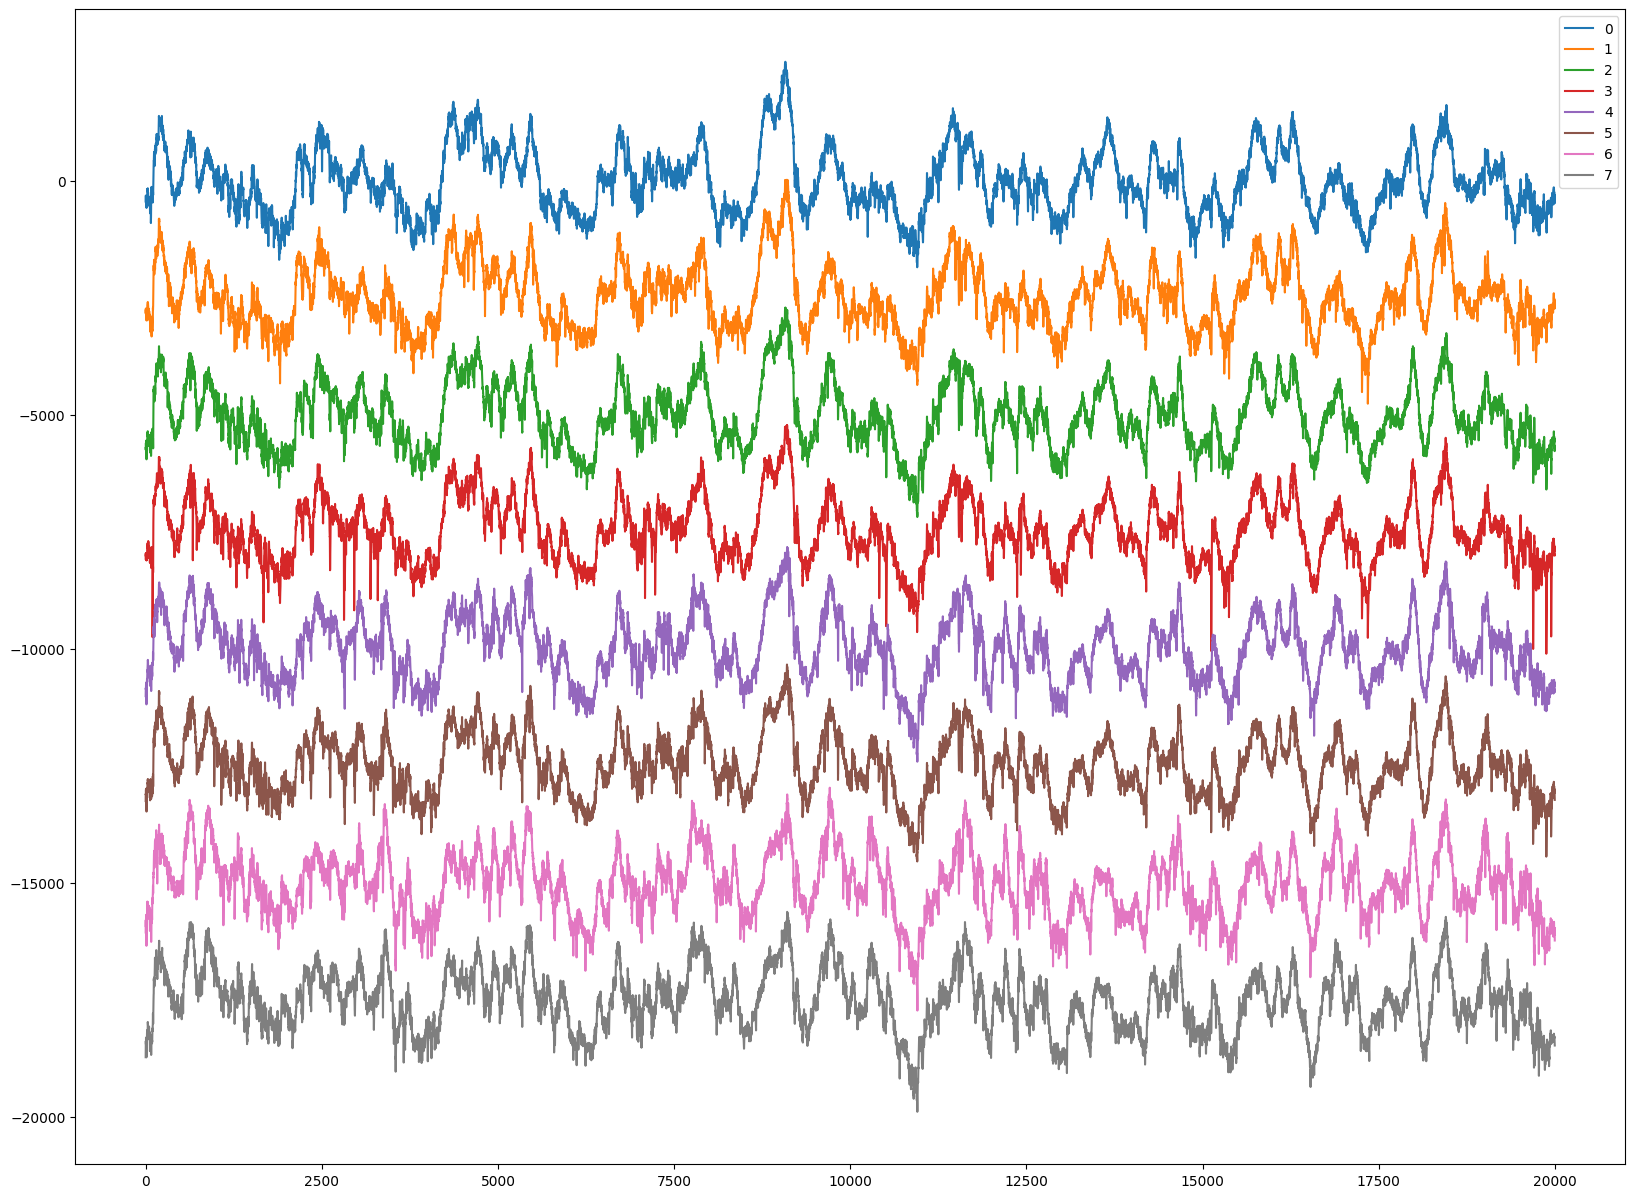

Detection chan 0, 5 spikes
Detection chan 1, 17 spikes
Detection chan 2, 12 spikes
Detection chan 3, 23 spikes
Detection chan 4, 28 spikes
Detection chan 5, 22 spikes
Detection chan 6, 17 spikes
Detection chan 7, 7 spikes


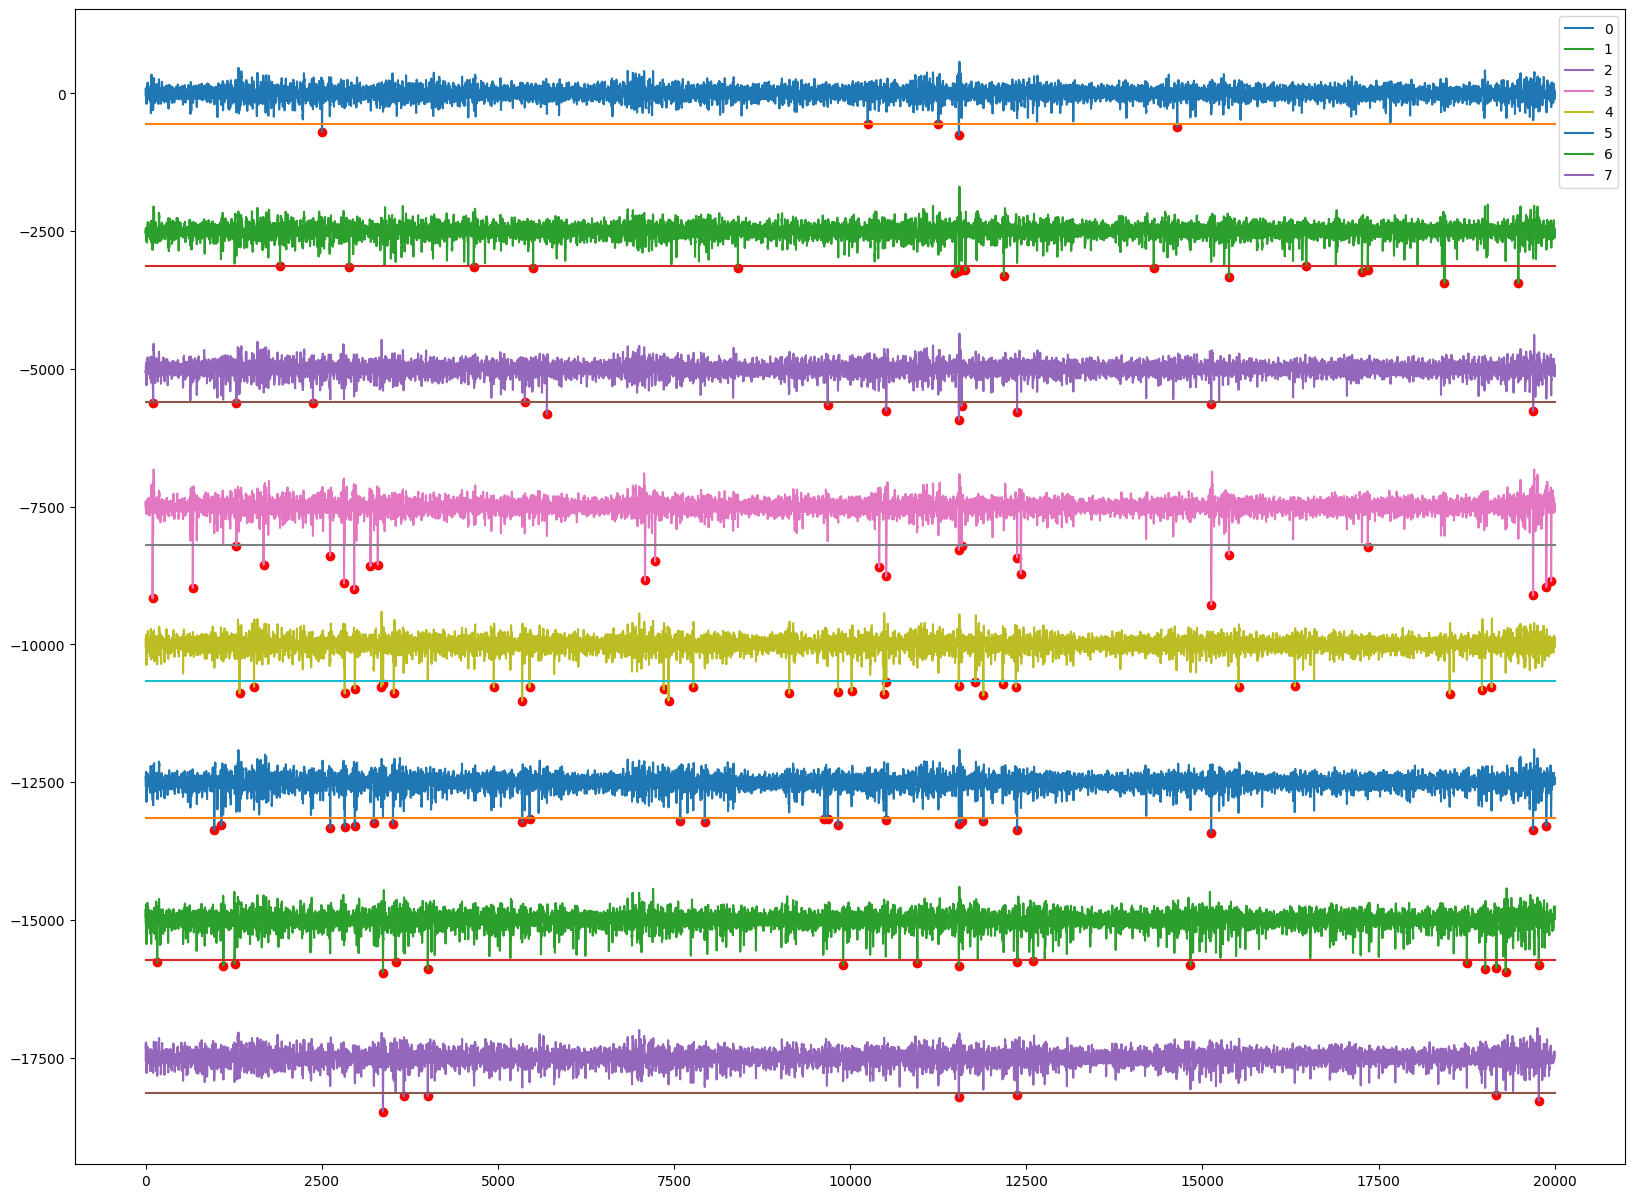

In [17]:
# variables for spike detection
fs = 20000 # sampling rate
lowcut=300
z=5
offset=2500

# load the data
fileName = "../data/shortRaw.npy" # binder users or people with a local git repository
dat = np.load(fileName)

# plot the data and run all the analyses performed so far
spikeDetection.plot_recording_data(dat,startSample=0,endSample=20000,offset=offset)
y = spikeDetection.filter_raw_data(dat,lowcut = lowcut, fs=fs)  # filter the data
spikeTimesList, thresholds = spikeDetection.spike_detection(y,z=z) # detect the spikes
spikeDetection.plot_spike_detection(y,spikeTimesList,thresholds,offset)

By using functions, you can perform many steps in a few lines of code.

***
## Extracting spike waveforms


### We need more than 1 second of data

For the next steps, we will need a longer recording duration so that we have more spikes to work with. We want to make sure that most neurons have the opportunity to fire a many spikes. This will make the clustering steps easier.

The file is in the `dataScienceNeuro/data/` folder.

https://github.com/kevin-allen/dataScienceNeuro/blob/main/data/longRaw.npy



You can load a new data file containing more samples.

In [18]:
# load the data
fs=20000
fileName = "../data/longRaw.npy" # binder users or people with a local git repository
dat = np.load(fileName)
print(dat.shape,"seconds:",dat.shape[1]/fs)

(8, 1200000) seconds: 60.0


We have more than a million samples

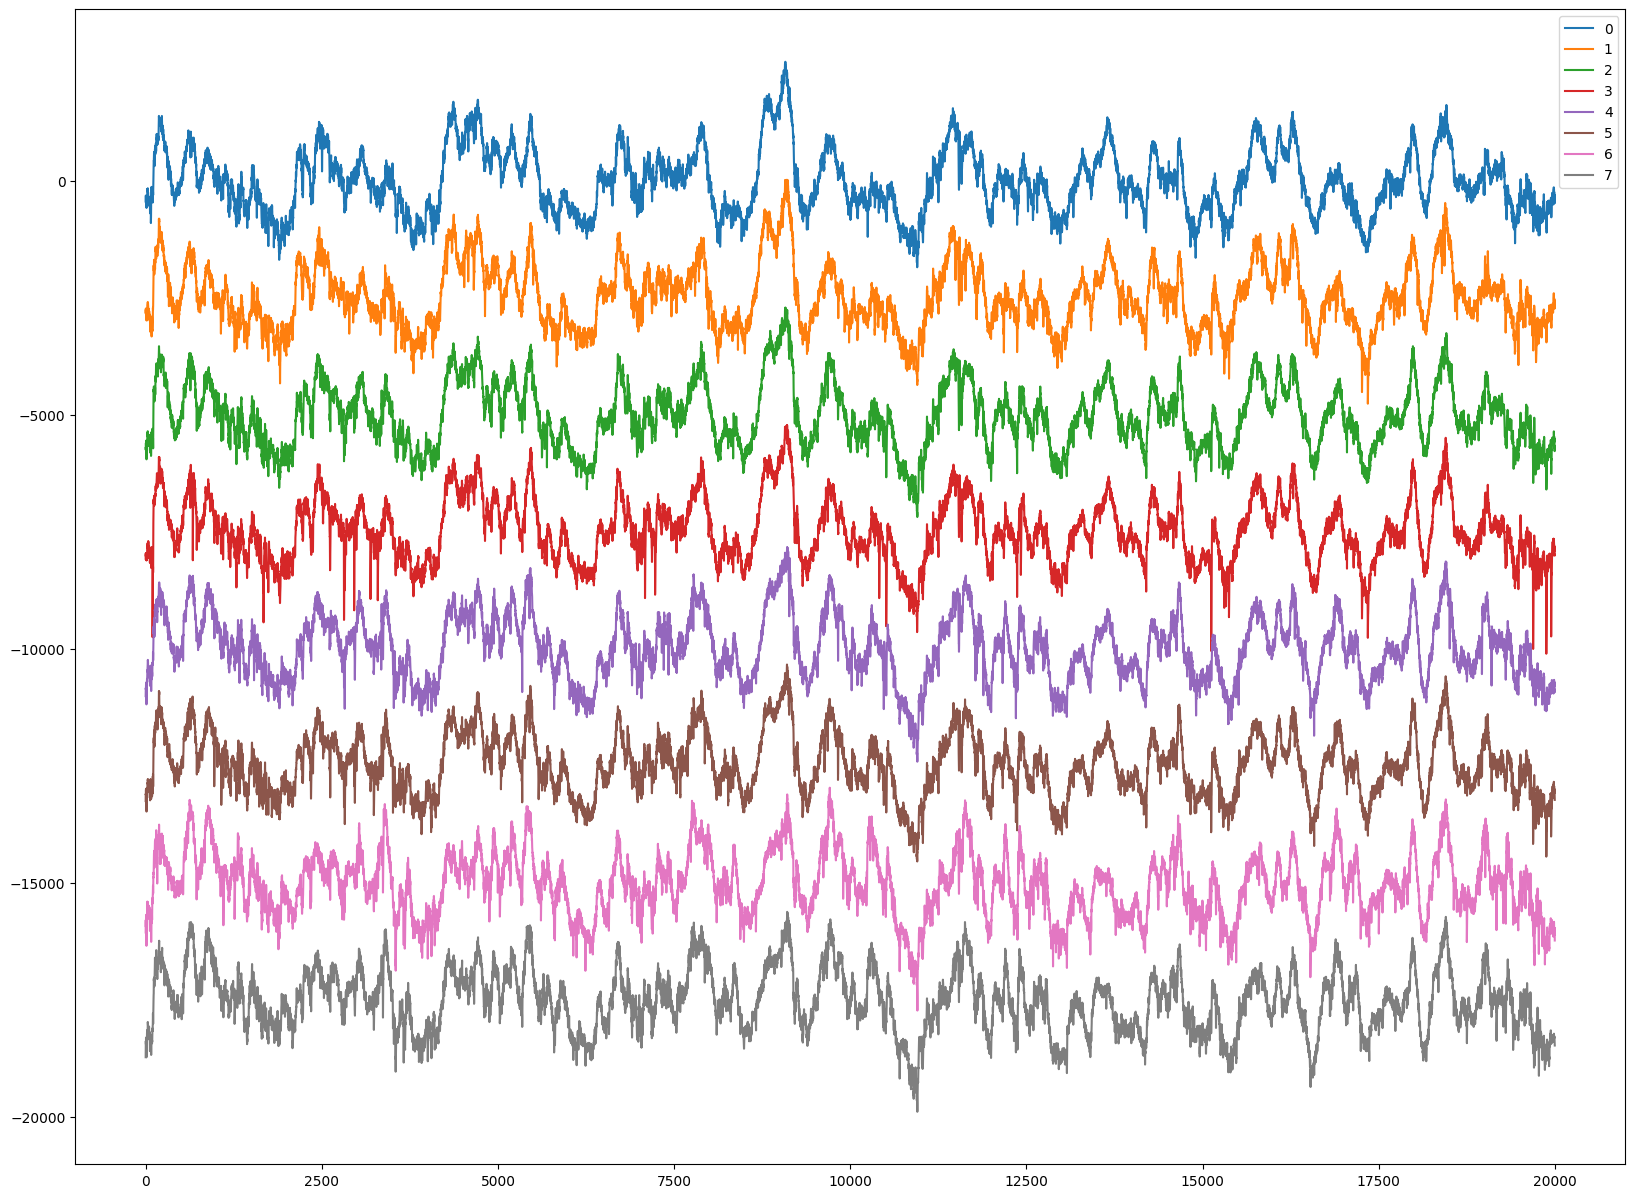

Detection chan 0, 123 spikes
Detection chan 1, 363 spikes
Detection chan 2, 134 spikes
Detection chan 3, 656 spikes
Detection chan 4, 612 spikes
Detection chan 5, 256 spikes
Detection chan 6, 224 spikes
Detection chan 7, 278 spikes
CPU times: user 644 ms, sys: 236 ms, total: 880 ms
Wall time: 673 ms


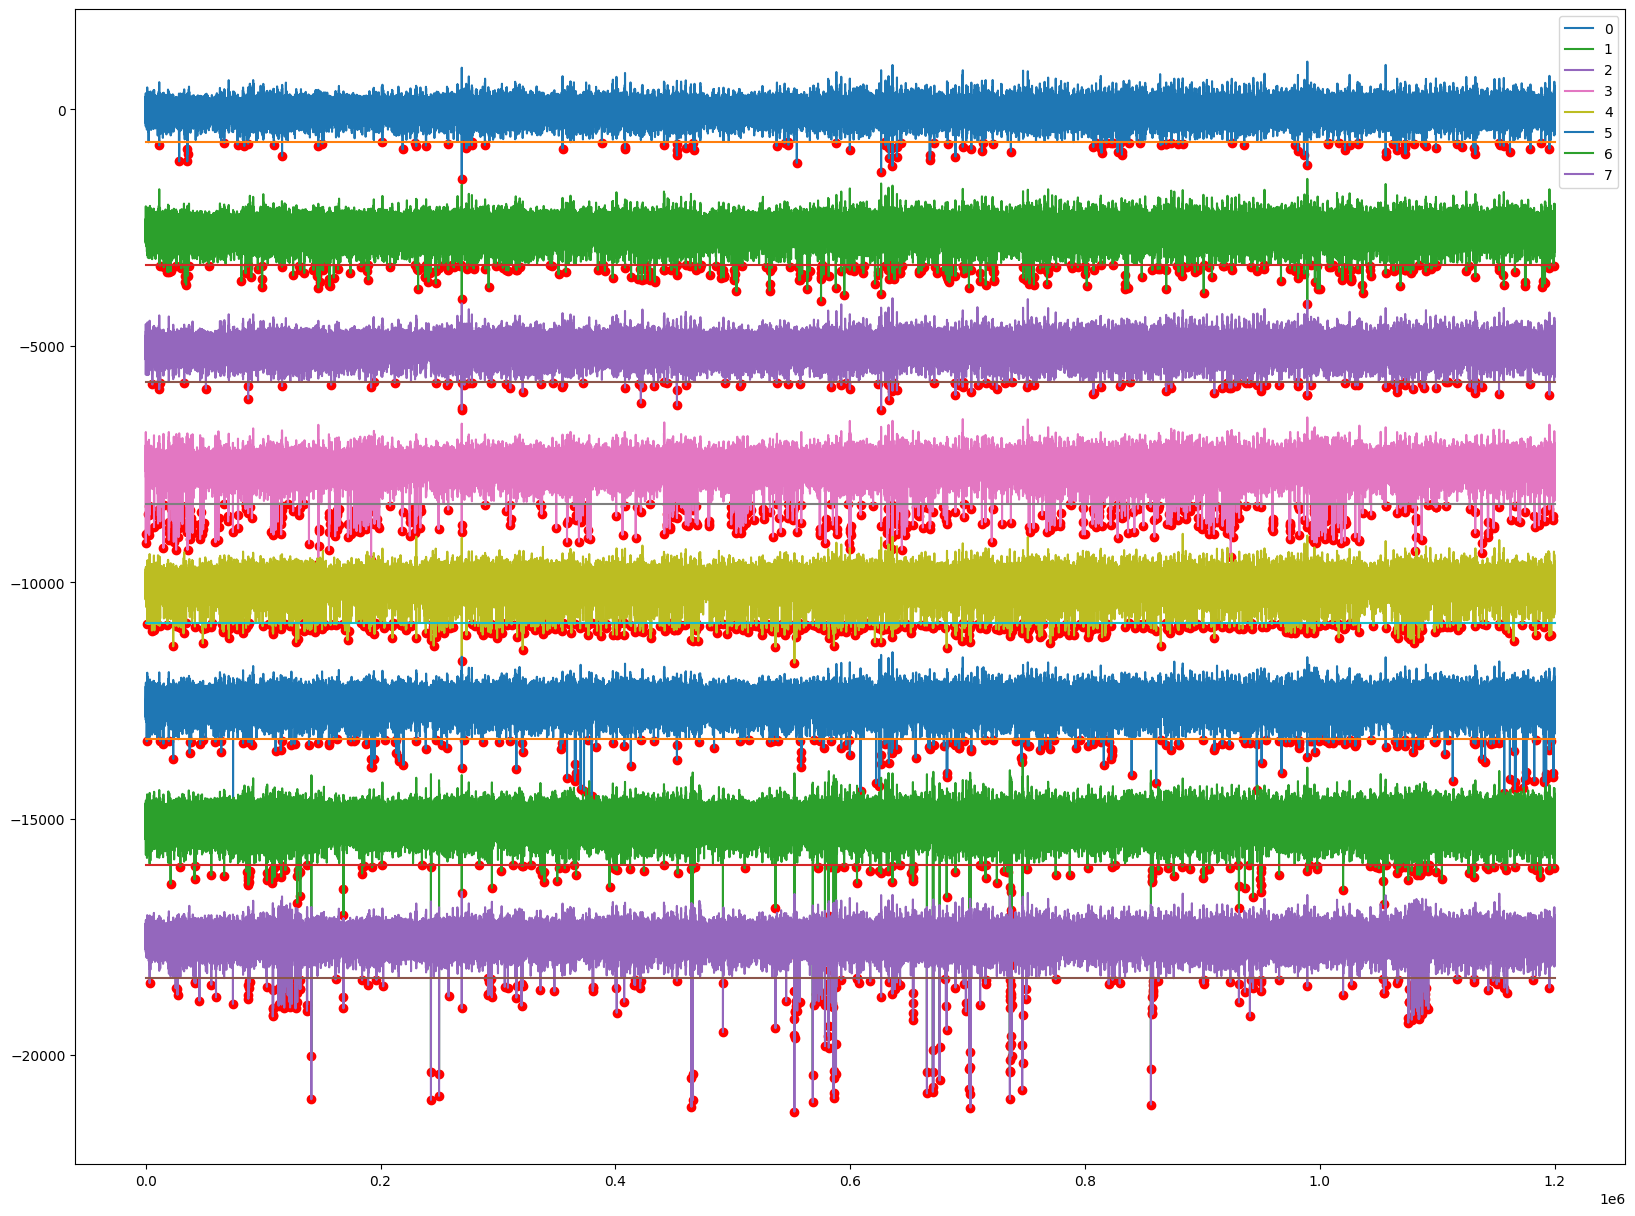

In [19]:
%%time
# plot the data and run all the analysis performed so far
z=6
spikeDetection.plot_recording_data(dat,startSample=0,endSample=20000,offset=offset)
y = spikeDetection.filter_raw_data(dat,lowcut = lowcut, fs=fs)  # filter the data
spikeTimesList, thresholds = spikeDetection.spike_detection(y,z=z) # detect the spikes
spikeDetection.plot_spike_detection(y,spikeTimesList,thresholds,offset)

To make our task easy, we will work on the spikes detected on channel 3, 5 and 7. 

Number of spikes:  1134


(0.0, 100000.0)

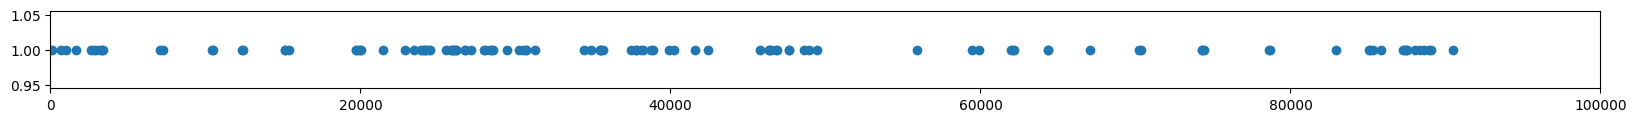

In [20]:
spikeTimes = np.concatenate([spikeTimesList[3],spikeTimesList[5],spikeTimesList[7]])
spikeTimes.sort()
spikeTimes = np.unique(spikeTimes)

print("Number of spikes: ", spikeTimes.shape[0])

# plot 1 second of spikes
plt.figure(figsize=(20,1))
plt.scatter(spikeTimes,np.ones_like(spikeTimes))
plt.xlim(0,100000)

We have detected several spikes on channel 3. In this steps, we want to extract the waveforms for these spikes from the filtered signal and store it in a new NumPy array.

<div>
<img src="../images/spike_extraction.png" width="800"/>
</div>

To do this, we need to decide on how many samples we collect per spike. 40 could be a reasonable choice. This is 1 ms before and 1 ms after the spike negative peak. 


* Axis 0: 8 channels
* Axis 1: 40 samples
* Axis 2: many spikes



Let's create our 3D array to store our spike waveforms.

In [21]:
print("dat shape:",dat.shape)
print("spikeTimes shape:", spikeTimes.shape)

dat shape: (8, 1200000)
spikeTimes shape: (1134,)


In [22]:
samplesPerSpike=40
waveforms=np.empty((dat.shape[0],samplesPerSpike,spikeTimes.shape[0]))
print("Shape of the waveforms array:",waveforms.shape)

Shape of the waveforms array: (8, 40, 1134)


### Exercise

Extract a first spike to test our strategy.

st: 98
start_index: 78 end_index: 118
shape of one waveform in waveform array: (8, 40)
shape of one waveform in y data: (8, 40)


As always, plot your results to make sure it looks like you expect.

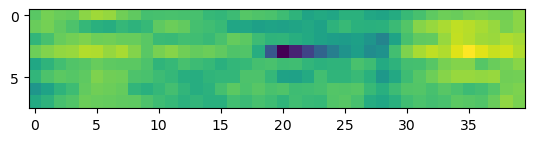

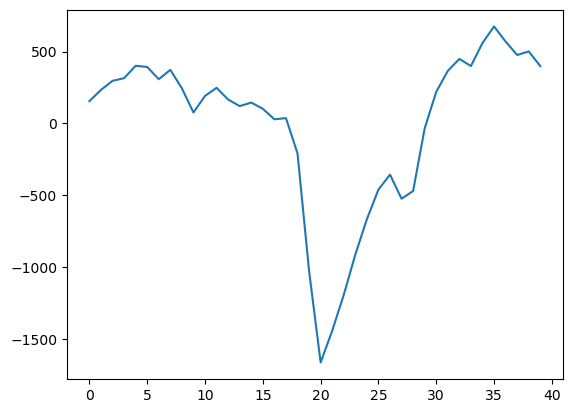

In [16]:
plt.imshow(waveforms[:,:,0]) #first waveform (2D array)
plt.show()
plt.plot(waveforms[3,:,0]) # first waveform, 4th channel (1D array)
plt.show()

Extract all 1005 spikes

In [17]:
for i,st in enumerate(spikeTimes):
    start_index=int(st-samplesPerSpike/2)
    end_index=int(st+samplesPerSpike/2)
    waveforms[:,:,i] = y[:,start_index:end_index]

## Visualize your results

As always, **visualize your results**. As 3D plots are hard to visualize, we will plot a series of 2D plots.

Here are some guidlines to visualize the content of NumPy arrays of different dimensions. 

#### 1D 
* plt.plot(x)
* plt.hist(x)

#### 2D
* plt.plot(x[i,:]
* plt.hist(x[i,:]))
* plt.imshow()

#### 3D
* plt.plot(x[i,j,:])
* plt.imshow(x[i,:,:])

In our case, we will use `plt.imshow()` several times, once per spike.

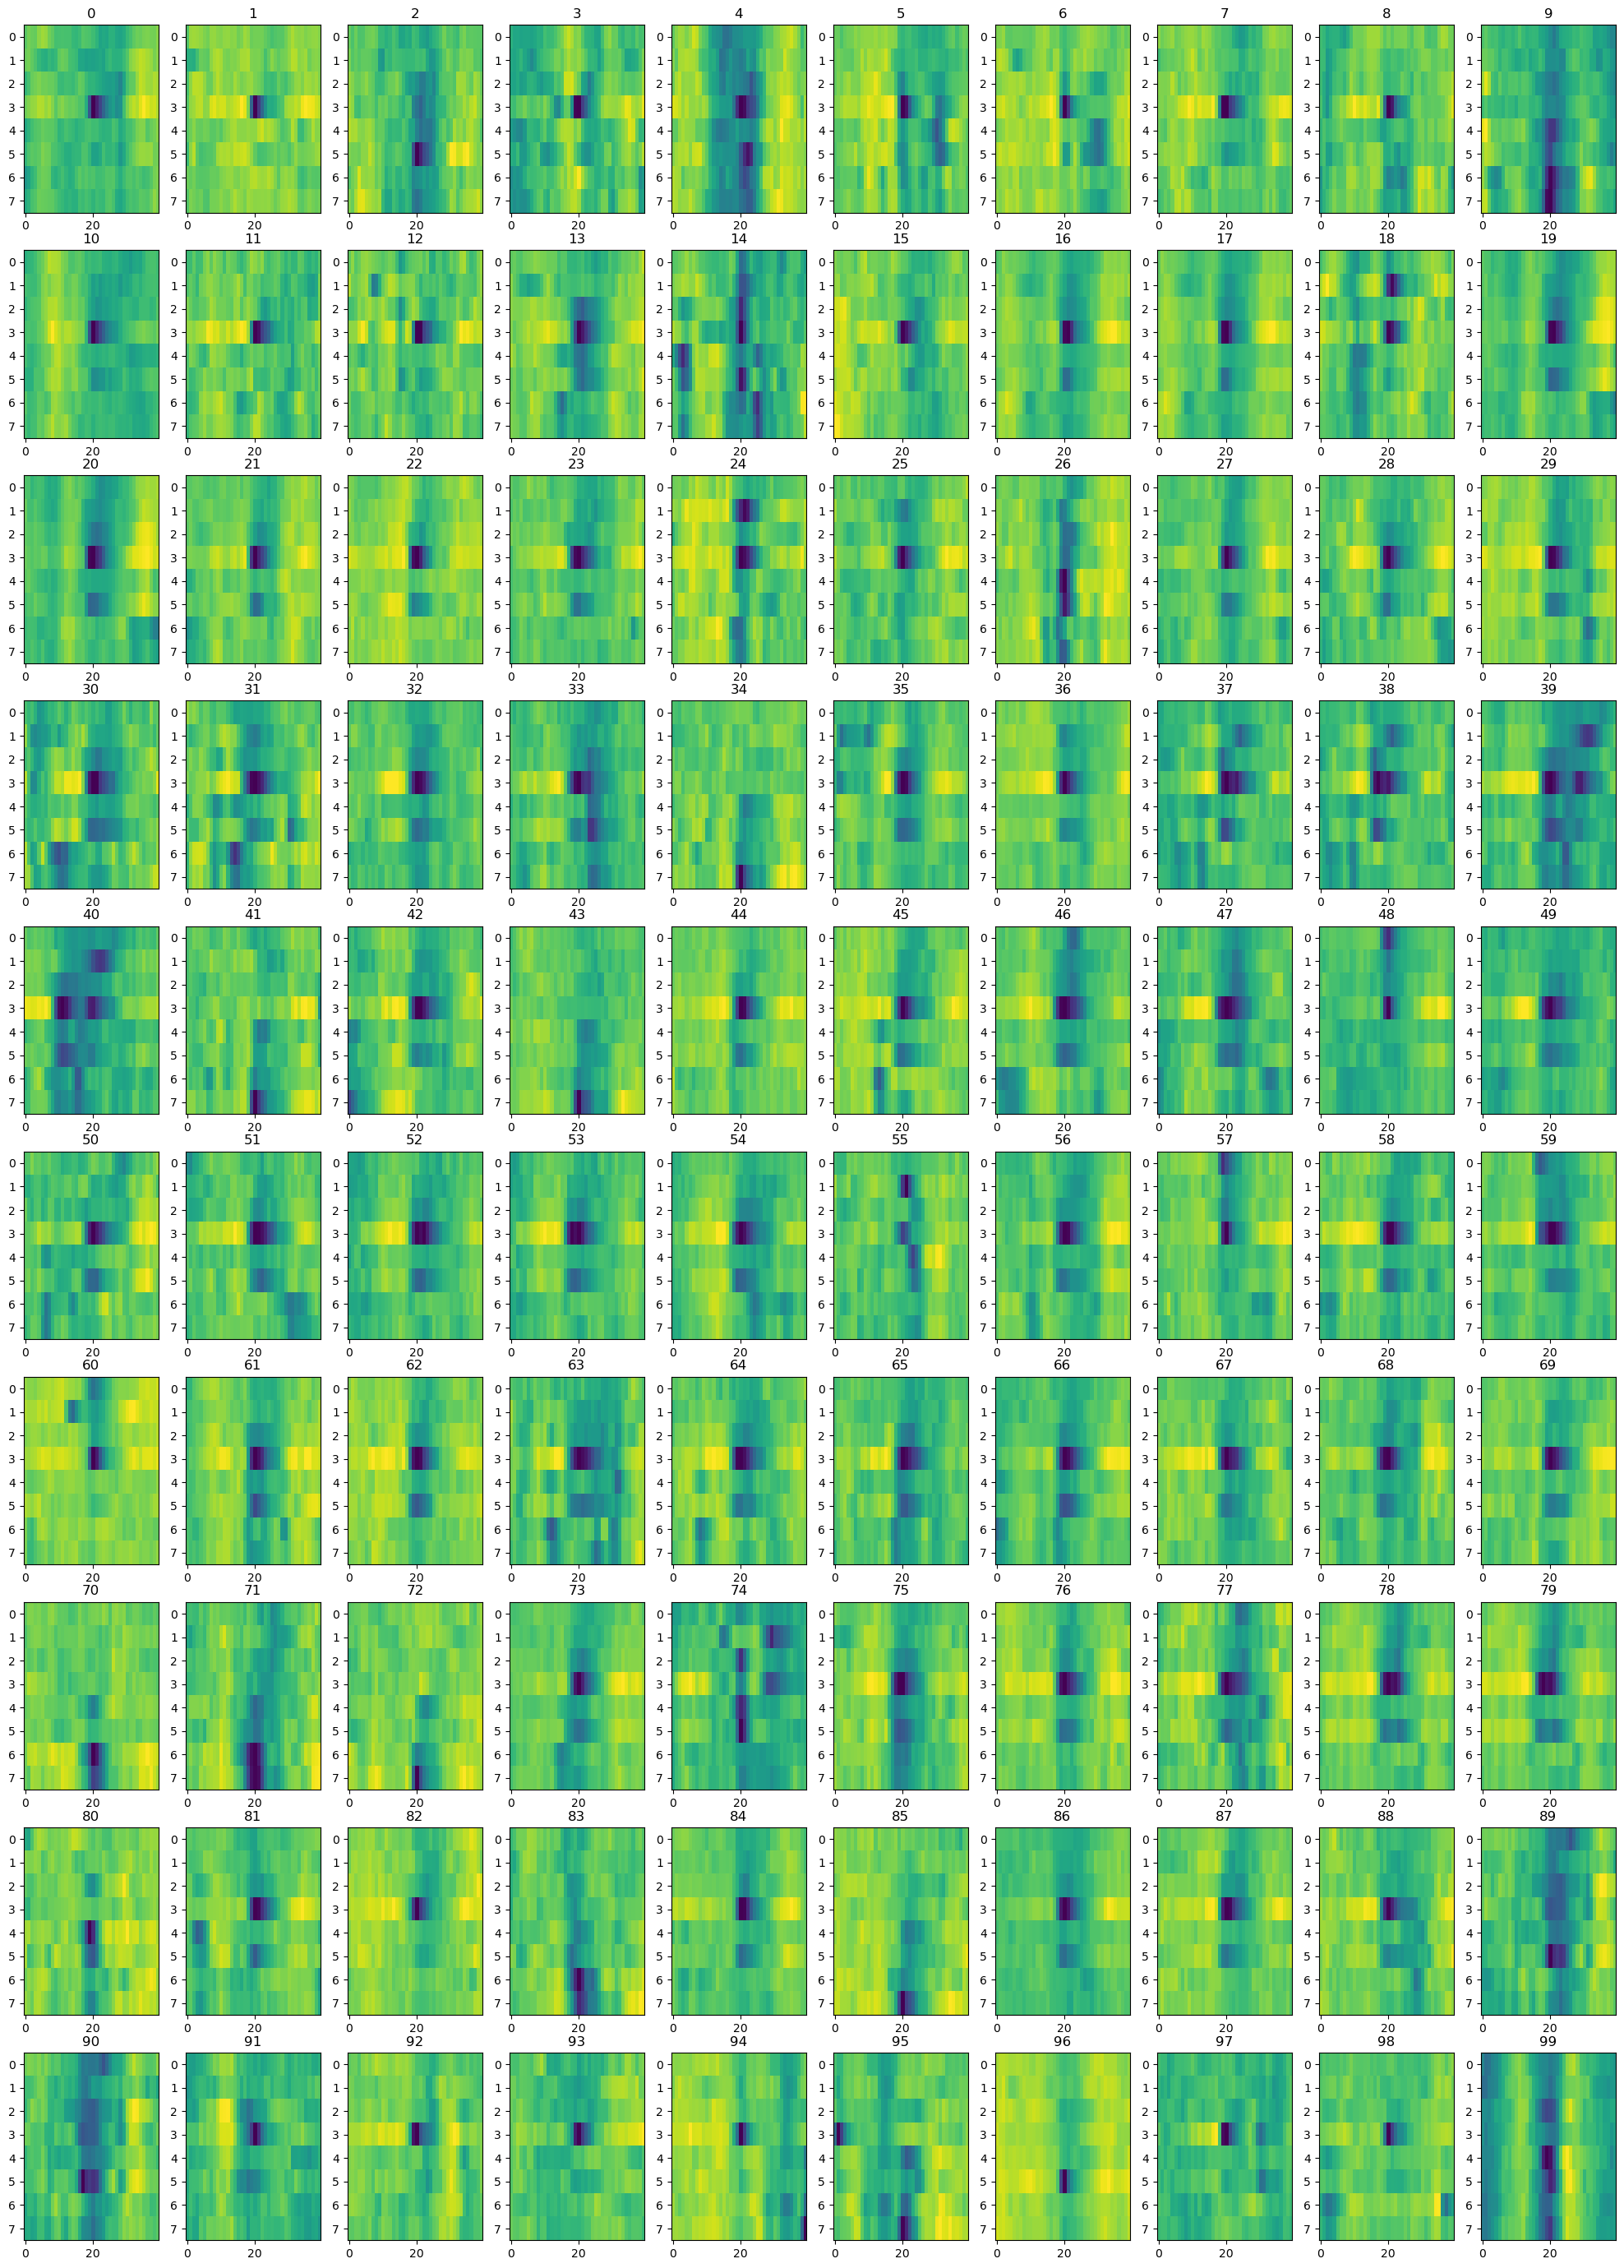

In [18]:
nrow=10
ncol=10
fig, ax = plt.subplots(nrow,ncol,figsize=(25,35))
for i in range(100):
    
    ax[int(i/ncol),i%ncol].imshow(waveforms[:,:,i],aspect="auto",interpolation="none")
    ax[int(i/ncol),i%ncol].set_title(i)

## Discussion

* What do you see in this figure? What is on the x-axis and y-axis of each image?
* Do you notice some patterns in the data?
* Are there spikes that are clearly different from the other ones?
* Do you think there are groups of spikes with similar waveforms that might originate from the same neuron?

***
# Summary

Here is what we have done today. 

* Filter raw 1D signals using SciPy.
* Organize our code into functions.
* Continue to learn to use NumPy arrays.
* Know that anyone good at data science is plotting its data all the time.


# Next session:

* Perform dimensionality reduction so describe our spike waveforms a few data points.
* Perform clustering analysis to test if we can group our spikes into putative neurons.